#### Import Required Libraries

In [188]:
import os
import numpy as np
import random
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import earthpy.plot as ep

#### Initial setup

In [189]:
ignore_index = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def setSeed(seed=47):
    # Set the seed for Python's random module.
    random.seed(seed)
    # Set the seed for NumPy.
    np.random.seed(seed)
    # Set the seed for PyTorch.
    torch.manual_seed(seed)
    # If you're using CUDA, set the seed for it as well.
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

setSeed(47)


#### Data acquisition and EDA

Data shape: (610, 340, 103) Labels shape: (610, 340)


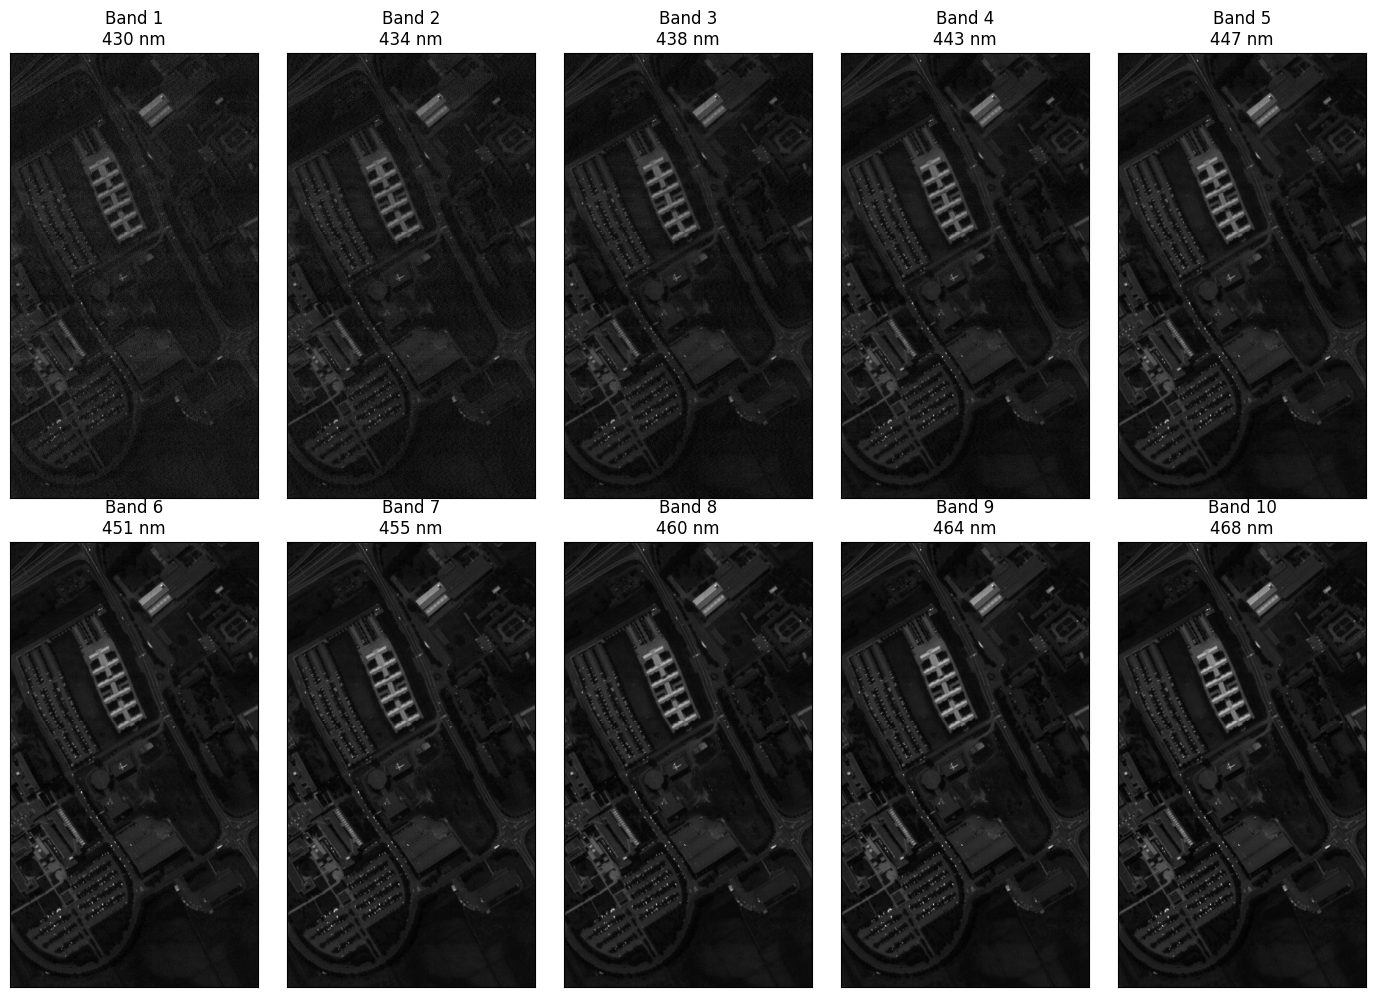

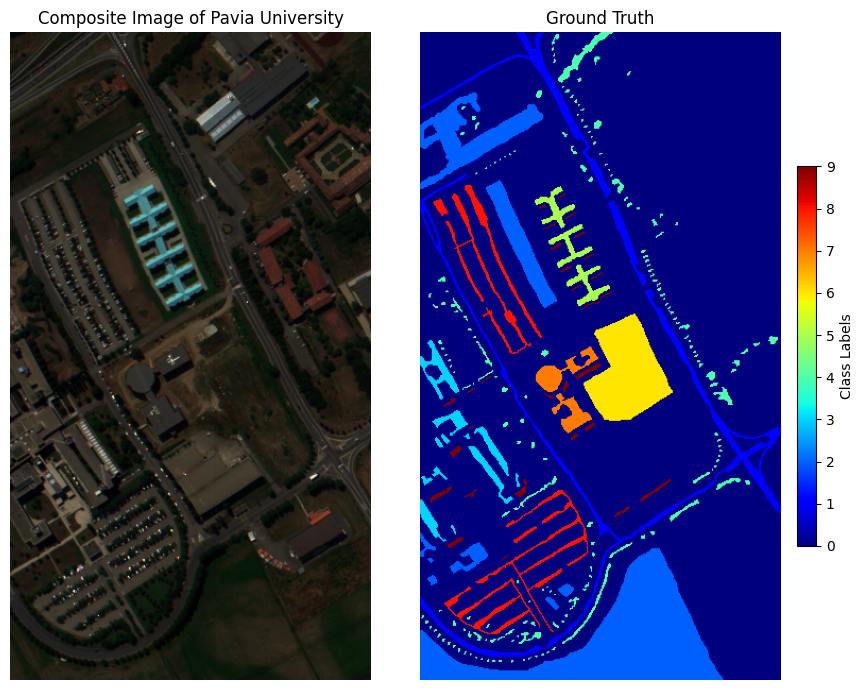

In [206]:
def loadPaviaUData(data_path='./pavia'):

    data = sio.loadmat('./Pavia/PaviaU.mat')['paviaU']
    labels = sio.loadmat('./Pavia/PaviaU_gt.mat')['paviaU_gt']

    #data = sio.loadmat('./indian-pines/Indian_pines_corrected.mat')['indian_pines_corrected']
    #labels = sio.loadmat('./indian-pines/Indian_pines_gt.mat')['indian_pines_gt']

    #data = sio.loadmat('./salinas/Salinas_corrected.mat')['salinas_corrected']
    #labels = sio.loadmat('./salinas/Salinas_gt.mat')['salinas_gt']
    return data, labels

def computeWavelengths(numBands, start=430, end=860):
   # Compute evenly spaced wavelengths across the specified spectral range.
    wavelengths = np.linspace(start, end, numBands)
    return np.round(wavelengths).astype(int)

def rgbComposer(hyperData, rgb=(60, 30, 10)):

    # Select the specified bands
    R = hyperData[rgb[0]].astype(np.float32)
    G = hyperData[rgb[1]].astype(np.float32)
    B = hyperData[rgb[2]].astype(np.float32)
    
    # Normalize each channel separately to [0, 1]
    def normalize(channel):
        channel_min = channel.min()
        channel_max = channel.max()
        return (channel - channel_min) / (channel_max - channel_min + 1e-10)
    
    R_norm = normalize(R)
    G_norm = normalize(G)
    B_norm = normalize(B)
    
    # Stack the channels along the last dimension to create an RGB image.
    composite = np.stack([R_norm, G_norm, B_norm], axis=-1)
    return composite


# Load the dataset (adjust the path as needed)
X, y = loadPaviaUData()
hyperData = X
hyperGT = y
print("Data shape:", X.shape, "Labels shape:", y.shape)

hyperData = np.moveaxis(hyperData, 2, 0)

# Compute wavelengths after loading the dataset
numBands = hyperData.shape[0]  # Get number of bands from data shape
wavelengths = computeWavelengths(numBands)

ep.plot_bands(hyperData[:10, :, :],
             title=[f'Band {i+1}\n{wavelengths[i]} nm' for i in range(10)],
             cmap='gist_gray',
             cols=5,
             cbar=False,
             scale=True,
             figsize=(14, 10))
plt.show()

# Generate and save the composite image into a variable.
rgbImg = rgbComposer(hyperData, rgb=(60, 30, 10))

# Create a figure with two subplots side by side
plt.figure(figsize=(9, 7))

# Left subplot: RGB composite image
plt.subplot(1, 2, 1)
plt.imshow(rgbImg)
plt.title('Composite Image of Pavia University')
plt.axis('off')

# Right subplot: Ground truth using a continuous colormap ('jet')
plt.subplot(1, 2, 2)
plt.imshow(hyperGT, cmap='jet')
plt.title('Ground Truth')
plt.axis('off')
plt.colorbar(label='Class Labels', fraction=0.046, pad=0.04)

# Display the combined plot
plt.tight_layout()
plt.show()

C:\Users\adela\AppData\Local\Temp\ipykernel_7248\2323502525.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=counts, palette="viridis")


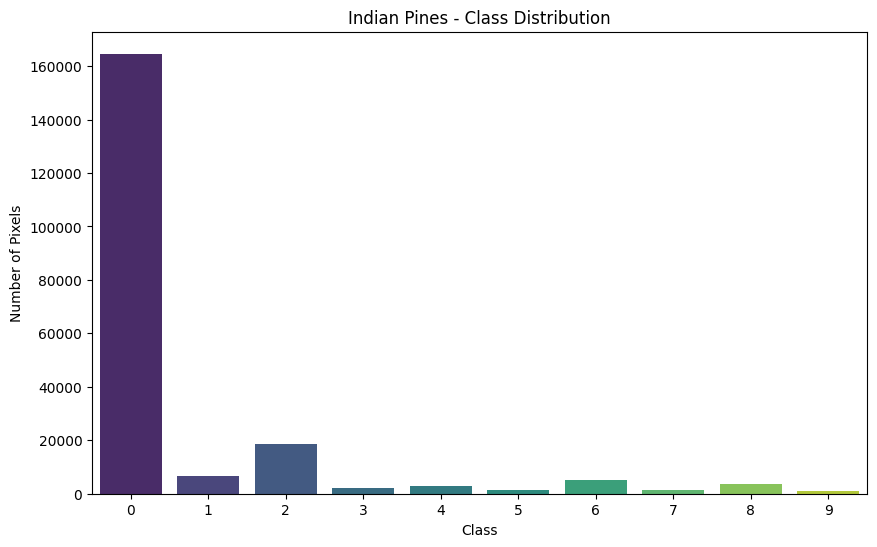

In [207]:
def plot_class_distribution(labels, title='Class Distribution'):
    """
    Plots the distribution of classes present in the labels.

    Args:
        labels (numpy array): Ground truth labels (2D array) or flattened array.
        title (str): Title for the plot.
    """
    # Ensure labels are flattened if they are not already.
    labels_flat = labels.flatten()
    unique_labels, counts = np.unique(labels_flat, return_counts=True)

    # Create a bar plot using Matplotlib or Seaborn.
    plt.figure(figsize=(10, 6))
    sns.barplot(x=unique_labels, y=counts, palette="viridis")
    plt.xlabel('Class')
    plt.ylabel('Number of Pixels')
    plt.title(title)
    plt.xticks(unique_labels)
    plt.show()

# Example: using the entire ground truth image of Indian Pines.
# Assume 'y' is your ground truth loaded for Indian Pines.
plot_class_distribution(y, title='Indian Pines - Class Distribution')

#### Data Normalization --> PCA with CVCR (cumulative variance contribution rate) – Determine Optimal Components and Apply PCA


In [191]:
def minmaxNormalize(data): # Function for min–max normalization

    # Calculate the minimum value in the data array.
    minValue = np.min(data)
    # Calculate the maximum value in the data array.
    maxValue = np.max(data)
    # Subtract the minimum value from every element, and divide by the range (max - min)
    normalizedData = (data - minValue) / (maxValue - minValue)
    # Return the normalized array.
    return normalizedData

def zscoreNormalize(data): # Function for z-score normalization
    # Scales data to have a mean of 0 and a standard deviation of 1.

    # Compute the mean value of the data array.
    meanValue = np.mean(data)
    # Compute the standard deviation of the data array.
    stdValue = np.std(data)
    # Subtract the mean from every element and divide by the standard deviation.
    normalizedData = (data - meanValue) / stdValue
    # Return the standardized array.
    return normalizedData

X = minmaxNormalize(X) # Normalize data

def optimComponentsCalc(X, threshold=0.9999, plot=False):

    reshaped_X = X.reshape(-1, X.shape[2])
    pca_full = PCA().fit(reshaped_X)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    optimal_components = int(np.argmax(cumulative_variance >= threshold) + 1)
    
    if plot:
        plt.figure(figsize=(8,5))
        plt.plot(cumulative_variance, marker='o')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Explained Variance vs. Number of PCA Components')
        plt.axhline(y=threshold, color='r', linestyle='--', 
                    label=f'{threshold*100:.2f}% Threshold')
        plt.legend()
        plt.show()
    
    return optimal_components

# Choose the threshold based on the paper (99.99% for Salinas; adjust if needed for Pavia)
# optimComponents = optimComponentsCalc(X, threshold=0.9999, plot=True)
optimComponents = 31 # Based on paper
print("Optimal number of PCA components based on CVCR:", optimComponents)

def applyPCA(X, numComponents):

    reshaped_X = X.reshape(-1, X.shape[2])
    pca = PCA(n_components=numComponents, whiten=False)
    pca_X = pca.fit_transform(reshaped_X)
    newX = pca_X.reshape(X.shape[0], X.shape[1], numComponents)
    return newX, pca

# Apply PCA to our data using the optimal number of components.
X_reduced, pca_model = applyPCA(X, numComponents=optimComponents)
print("Reduced data shape:", X_reduced.shape)


Optimal number of PCA components based on CVCR: 31
Reduced data shape: (610, 340, 31)


#### Custom Dataset for Non-Overlapping Patch Extraction

In [192]:
class PaviaDataset(Dataset):
    def __init__(self, X, y, patch_side=32, transform=None):
        self.X = X
        self.y = y
        self.patch_side = patch_side
        self.transform = transform

        # For non-overlapping patches, stride equals patch_side.
        self.stride = patch_side

        # Calculate the number of patches along each dimension.
        n1 = (X.shape[0] - patch_side) // self.stride + 1
        n2 = (X.shape[1] - patch_side) // self.stride + 1
        self.n_patches = n1 * n2

        # Generate patch coordinates as tuples: (row_start, row_end, col_start, col_end)
        self.patch_coords = []
        for i in range(n1):
            for j in range(n2):
                row_start = i * self.stride
                row_end = row_start + patch_side
                col_start = j * self.stride
                col_end = col_start + patch_side
                self.patch_coords.append((row_start, row_end, col_start, col_end))
                
    def __len__(self):
        return self.n_patches
    
    def __getitem__(self, idx):
        row_start, row_end, col_start, col_end = self.patch_coords[idx]
        patch_X = self.X[row_start:row_end, col_start:col_end, :]
        patch_y = self.y[row_start:row_end, col_start:col_end]
        
        # Convert types.
        patch_X = patch_X.astype(np.float32)
        patch_y = patch_y.astype(np.int64)
        
        # If a transform is provided, use Albumentations.
        if self.transform:
            # Albumentations expects the image in HWC order.
            # If your patch_X is already in HWC (i.e., shape is (H, W, channels)), do nothing.
            # Otherwise, if patch_X is in CHW, then transpose.
            if patch_X.shape[0] == self.X.shape[2]:
                # patch_X is in shape (channels, H, W). Convert to (H, W, channels)
                patch_X = np.transpose(patch_X, (1, 2, 0))
            # Apply the augmentation. patch_y remains (H, W)
            augmented = self.transform(image=patch_X, mask=patch_y)
            # The transform's ToTensorV2 converts image to a torch tensor of shape (C, H, W)
            patch_X = augmented['image']
            # Convert the mask to a torch tensor (if needed).
            patch_y = torch.as_tensor(augmented['mask'], dtype=torch.long)
        else:
            # If no augmentation, convert patch_X to a torch tensor in (C, H, W) order.
            patch_X = torch.from_numpy(patch_X).permute(2, 0, 1)
            patch_y = torch.from_numpy(patch_y)

        return patch_X, patch_y


# Custom transform for spectral augmentation
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    # Add more transforms if needed.
    ToTensorV2()
])


# Create an instance of the dataset using the reduced data.
dataset = PaviaDataset(X_reduced, y, patch_side=32)
print("Number of patches in dataset:", len(dataset))

# 2. Dataset with augmentation (for training only), using your Albumentations pipeline or any custom augmentations.
augDataset = PaviaDataset(X_reduced, y, patch_side=32, transform=augmentation)

Number of patches in dataset: 190


#### Split the Dataset and Create DataLoaders

In [193]:
def classPatchDistro(indices, dataset, n_classes):
    # Checks whether the patches corresponding to the given indices cover all classes.

    covered_classes = set()
    for i in indices:
        # Each sample is a tuple: (patch_X, patch_y)
        _, patch_y = dataset[i]
        # Get unique labels from this patch (patch_y is a tensor)
        unique_labels = torch.unique(patch_y).tolist()
        covered_classes.update(unique_labels)
    # Check that every class from 0 to n_classes-1 is present.
    return all(cls in covered_classes for cls in range(n_classes))

def evenDistroSplit(dataset, ratio_train=0.6, ratio_val=0.2, ratio_test=0.2, n_classes=2, max_iter=1000):
    # Splits the dataset indices into train, validation, and test subsets with the specified ratios,

    indices = np.arange(len(dataset))
    for i in range(max_iter):
        # Randomly split indices into train and temporary (val+test)
        train_idx, temp_idx = train_test_split(indices, test_size=(ratio_val + ratio_test), 
                                               random_state=np.random.randint(0, 10000))
        # Split temp_idx into validation and test according to the specified ratio.
        val_ratio = ratio_val / (ratio_val + ratio_test)
        val_idx, test_idx = train_test_split(temp_idx, test_size=(1 - val_ratio), 
                                             random_state=np.random.randint(0, 10000))
        # Check coverage in each subset.
        if (classPatchDistro(train_idx, dataset, n_classes) and 
            classPatchDistro(val_idx, dataset, n_classes) and 
            classPatchDistro(test_idx, dataset, n_classes)):
            return train_idx, val_idx, test_idx
    raise Exception("Unable to split dataset with full class coverage after {} iterations.".format(max_iter))

# Assume we have already set up our PaviaDataset instance named "dataset" and computed the number of classes.
# For example, if our ground truth label array 'y' has shape (H, W), we define:
n_classes = int(y.max()) + 1
print("Total number of classes:", n_classes)

# Now perform the split with class coverage assurance.
train_indices, val_indices, test_indices = evenDistroSplit(dataset, ratio_train=0.6, 
                                                                        ratio_val=0.2, ratio_test=0.2, 
                                                                        n_classes=n_classes)
print("Training patches:", len(train_indices))
print("Validation patches:", len(val_indices))
print("Testing patches:", len(test_indices))

# Create subsets using PyTorch's Subset class.
# trainSet = Subset(dataset, train_indices)
trainSet = Subset(augDataset, train_indices)
valSet = Subset(dataset, val_indices)
testSet = Subset(dataset, test_indices)

# Optionally, create DataLoaders from these subsets.
batch_size = 64
train_loader = DataLoader(trainSet, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valSet, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testSet, batch_size=batch_size, shuffle=False)


Total number of classes: 10
Training patches: 114
Validation patches: 38
Testing patches: 38


#### Define the Vanilla-UNet and PSE‑UNet Model(s)

In [194]:
# Define a regular double convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

# Define the Squeeze-and-Excitation (SE) block.
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
    
    def forward(self, x):
        # x shape: (batch, channels, H, W)
        b, c, _, _ = x.size()
        # Global Average Pooling: (batch, channels)
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = torch.sigmoid(y).view(b, c, 1, 1)
        return x * y

# Define a double convolution block with SE and PReLU.
class CSEModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CSEModule, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )
        self.se = SEBlock(out_channels)
    
    def forward(self, x):
        x = self.double_conv(x)
        x = self.se(x)
        return x


#----------------------------------------------------------------------------------------------------------
# Define the PSE-UNet (PSEUNET44) architecture

class PSEUNET44(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(PSEUNET44, self).__init__()
        # Encoder using CSE modules.
        self.encoder1 = CSEModule(in_channels, 64)
        self.pool1 = nn.Conv2d(64, 64, kernel_size=2, stride=2)  # Convolution with stride 2 for downsampling.
        
        self.encoder2 = CSEModule(64, 128)
        self.pool2 = nn.Conv2d(128, 128, kernel_size=2, stride=2)
        
        self.encoder3 = CSEModule(128, 256)
        self.pool3 = nn.Conv2d(256, 256, kernel_size=2, stride=2)
        
        self.encoder4 = CSEModule(256, 512)
        # No pooling after the last encoder.

        # Decoder using transposed convolution for upsampling.
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = CSEModule(512, 256)  # Concatenate encoder3 output and upsampled features.
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = CSEModule(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = CSEModule(128, 64)
        
        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)
    
    def forward(self, x):
        # Encoder pathway.
        enc1 = self.encoder1(x)  # Shape: (B, 64, H, W)
        enc2 = self.encoder2(self.pool1(enc1))  # (B, 128, H/2, W/2)
        enc3 = self.encoder3(self.pool2(enc2))  # (B, 256, H/4, W/4)
        enc4 = self.encoder4(self.pool3(enc3))  # (B, 512, H/8, W/8)
        
        # Decoder pathway.
        dec3 = self.up3(enc4)  # Upsample to (B, 256, H/4, W/4)
        # Concatenate with enc3 along channel dimension.
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.up2(dec3)  # (B, 128, H/2, W/2)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.up1(dec2)  # (B, 64, H, W)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        out = self.conv_last(dec1)
        return out
#----------------------------------------------------------------------------------------------------------

#----------------------------------------------------------------------------------------------------------
# Define the PSE-UNet (PSEUNET22) architecture
'''
class CSEModule22(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CSEModule22, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )
        self.se = SEBlock(out_channels, reduction=16)
    
    def forward(self, x):
        x = self.double_conv(x)
        x = self.se(x)
        return x


class PSEUNET22(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(PSEUNET22, self).__init__()
        # Encoder
        self.encoder1 = CSEModule22(in_channels, 32)      # Output: 32 channels
        self.pool1 = nn.Conv2d(32, 32, kernel_size=2, stride=2)  # Downsample by 2
        
        self.encoder2 = CSEModule22(32, 64)                # Output: 64 channels
        self.pool2 = nn.Conv2d(64, 64, kernel_size=2, stride=2)  # Downsample by 2
        
        # Bottleneck (no pooling)
        self.bottleneck = CSEModule22(64, 128)             # Output: 128 channels
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Upsample to match encoder2's resolution
        self.decoder1 = CSEModule22(64 + 64, 64)           # Concatenate with encoder2 output
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)   # Upsample to match encoder1's resolution
        self.decoder2 = CSEModule22(32 + 32, 32)           # Concatenate with encoder1 output
        
        self.conv_last = nn.Conv2d(32, n_classes, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        up1 = self.up1(bottleneck)
        dec1 = self.decoder1(torch.cat([up1, enc2], dim=1))
        up2 = self.up2(dec1)
        dec2 = self.decoder2(torch.cat([up2, enc1], dim=1))
        out = self.conv_last(dec2)
        return out


'''

class CSEModule22(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super(CSEModule22, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )
        self.se = SEBlock(out_channels, reduction=16)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.double_conv(x)
        x = self.se(x)
        return self.dropout(x)

'''
class PSEUNET22(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(PSEUNET22, self).__init__()
        # Encoder
        self.encoder1 = CSEModule22(in_channels, 32, dropout_rate=0.2)      # Output: 32 channels
        self.pool1 = nn.Conv2d(32, 32, kernel_size=2, stride=2)            # Downsample by 2
        
        self.encoder2 = CSEModule22(32, 64, dropout_rate=0.2)                 # Output: 64 channels
        self.pool2 = nn.Conv2d(64, 64, kernel_size=2, stride=2)            # Downsample by 2
        
        # Bottleneck (no pooling)
        self.bottleneck = CSEModule22(64, 128, dropout_rate=0.2)              # Output: 128 channels
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)    # Upsample to match encoder2's resolution
        self.decoder1 = CSEModule22(64 + 64, 64, dropout_rate=0.2)            # Concatenate with encoder2 output
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)     # Upsample to match encoder1's resolution
        self.decoder2 = CSEModule22(32 + 32, 32, dropout_rate=0.2)            # Concatenate with encoder1 output
        
        self.conv_last = nn.Conv2d(32, n_classes, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)                  # Shape: (B, 32, H, W)
        enc2 = self.encoder2(self.pool1(enc1))     # Shape: (B, 64, H/2, W/2)
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))  # Shape: (B, 128, H/4, W/4)
        
        # Decoder
        up1 = self.up1(bottleneck)                      # Shape: (B, 64, H/2, W/2)
        # Concatenate along channel dimension with encoder2 output.
        dec1_input = torch.cat([up1, enc2], dim=1)       
        dec1 = self.decoder1(dec1_input)                # Shape: (B, 64, H/2, W/2)
        
        up2 = self.up2(dec1)                            # Shape: (B, 32, H, W)
        # Concatenate with encoder1 output.
        dec2_input = torch.cat([up2, enc1], dim=1)
        dec2 = self.decoder2(dec2_input)                # Shape: (B, 32, H, W)
        
        out = self.conv_last(dec2)                      # Final segmentation map
        return out
'''

class PSEUNET22(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(PSEUNET22, self).__init__()
        # Encoder: Increase capacity by using higher channel counts.
        self.encoder1 = CSEModule22(in_channels, 64, dropout_rate=0.2)      # Output: 64 channels
        self.pool1 = nn.Conv2d(64, 64, kernel_size=2, stride=2)              # Downsample by 2
        
        self.encoder2 = CSEModule22(64, 128, dropout_rate=0.2)                # Output: 128 channels
        self.pool2 = nn.Conv2d(128, 128, kernel_size=2, stride=2)             # Downsample by 2
        
        # Bottleneck (no pooling)
        self.bottleneck = CSEModule22(128, 256, dropout_rate=0.2)             # Output: 256 channels
        
        # Decoder: Mirror the encoder with upsampling.
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)       # Upsample to match encoder2's resolution
        self.decoder1 = CSEModule22(128 + 128, 128, dropout_rate=0.2)           # Concatenate with encoder2 output
        
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)        # Upsample to match encoder1's resolution
        self.decoder2 = CSEModule22(64 + 64, 64, dropout_rate=0.2)              # Concatenate with encoder1 output
        
        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)               # Final segmentation map

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)                            # Shape: (B, 64, H, W)
        enc2 = self.encoder2(self.pool1(enc1))             # Shape: (B, 128, H/2, W/2)
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))     # Shape: (B, 256, H/4, W/4)
        
        # Decoder
        up1 = self.up1(bottleneck)                         # Shape: (B, 128, H/2, W/2)
        dec1_input = torch.cat([up1, enc2], dim=1)         # Shape: (B, 256, H/2, W/2)
        dec1 = self.decoder1(dec1_input)                   # Shape: (B, 128, H/2, W/2)
        
        up2 = self.up2(dec1)                               # Shape: (B, 64, H, W)
        dec2_input = torch.cat([up2, enc1], dim=1)         # Shape: (B, 128, H, W)
        dec2 = self.decoder2(dec2_input)                   # Shape: (B, 64, H, W)
        
        out = self.conv_last(dec2)                         # Final segmentation map (B, n_classes, H, W)
        return out

# ----------------------------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------------------------
# Define the Vanilla-UNet architecture

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.dconv_down1 = DoubleConv(n_channels, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = DoubleConv(256+512, 256)
        self.dconv_up2 = DoubleConv(128+256, 128)
        self.dconv_up1 = DoubleConv(128+64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        conv1 = self.dconv_down1(x)
        x1 = self.maxpool(conv1)

        conv2 = self.dconv_down2(x1)
        x2 = self.maxpool(conv2)

        conv3 = self.dconv_down3(x2)
        x3 = self.maxpool(conv3)

        x4 = self.dconv_down4(x3)

        # Decoder path
        x = self.upsample(x4)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        x = self.conv_last(x)
        return x
# ----------------------------------------------------------------------------------------------------------
# Define number of input channels and number of classes.
inChannels = optimComponents  # from PCA reduction

# Get the number of classes from y.
n_classes = int(y.max()) + 1  

# Instantiate the pse-unet44 model.
pseunet44 = PSEUNET44(in_channels=inChannels, n_classes=n_classes)
pseunet44 = pseunet44.to(device)
print("pseunet44 Model instantiated on device:", device)


# Instantiate the pse-unet22 model.
pseunet22 = PSEUNET22(in_channels=inChannels, n_classes=n_classes)
pseunet22 = pseunet22.to(device)
print("pseunet22 model instantiated on device:", device)


# Instantiate the vanilla-unet model.
vunet = UNet(n_channels=inChannels, n_classes=n_classes)
vunet = vunet.to(device)
print("vanilla-unet model instantiated on device:", device)

pseunet44 Model instantiated on device: cuda
pseunet22 model instantiated on device: cuda
vanilla-unet model instantiated on device: cuda


#### Initialization parameters

In [195]:
# Dataset highly unbalanced, compute Class Weights ----------------------------------------------------------

def classWeighting(dataset, n_classes):

    class_counts = np.zeros(n_classes, dtype=np.float32)
    from torch.utils.data import DataLoader
    # Use a DataLoader with batch_size=1 to iterate through patches
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    for _, patch_labels in loader:
        # Flatten the patch labels.
        labels_np = patch_labels.numpy().flatten()
        for c in range(n_classes):
            class_counts[c] += np.sum(labels_np == c)
    
    total = class_counts.sum()
    # Compute weights: total pixels divided by (n_classes * count for each class)
    weights = total / (n_classes * class_counts)
    return torch.tensor(weights, dtype=torch.float32)
# ------------------------------------------------------------------------------------------------------------




# Determine number of classes
n_classes = int(y.max()) + 1  
print("Total number of classes:", n_classes)

# Compute class weights from the training dataset 
class_weights = classWeighting(trainSet, n_classes)
print("Computed class weights:", class_weights)

# Define initial learning rate and weight decay
initial_lr = 0.001
weight_decay = 0.00001

# Define loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=class_weights.to(device))
#loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer for each model
pse44Optim = torch.optim.Adam(pseunet44.parameters(), lr=initial_lr, weight_decay=weight_decay) # (pseunet44) 
pse44Scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pse44Optim, mode='min', factor=0.5, patience=10, verbose=True) # Use the ReduceLROnPlateau scheduler: if validation loss doesn't decrease for 10 epochs, reduce LR by 0.5

pse22Optim = torch.optim.Adam(pseunet22.parameters(), lr=0.001) # (pseunet22)
pse22Scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pse22Optim, mode='min', factor=0.5, patience=10, verbose=True)

vunetOptim = torch.optim.Adam(vunet.parameters(), lr=0.001) # (vanilla-unet)
vunetScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(vunetOptim, mode='min', factor=0.5, patience=10, verbose=True)

Total number of classes: 10
Computed class weights: tensor([ 0.1230,  3.2373,  1.3074, 13.7014,  6.4962, 15.7538,  5.2395, 13.4179,
         5.1267, 22.7556])


C:\Users\adela\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#### Training and Evaluation Loops, and Loss Curves

Training vanilla-unet...
Epoch 1/100: Train Loss = 2.1857, Val Loss = 2.2848, LR = 0.001000
Training complete...
Epoch 2/100: Train Loss = 1.5851, Val Loss = 2.2733, LR = 0.001000
Training complete...
Epoch 3/100: Train Loss = 1.3716, Val Loss = 2.2547, LR = 0.001000
Training complete...
Epoch 4/100: Train Loss = 1.2546, Val Loss = 2.2744, LR = 0.001000
Training complete...
Epoch 5/100: Train Loss = 1.0815, Val Loss = 2.5054, LR = 0.001000
Training complete...
Epoch 6/100: Train Loss = 1.0151, Val Loss = 2.6386, LR = 0.001000
Training complete...
Epoch 7/100: Train Loss = 0.9157, Val Loss = 2.7135, LR = 0.001000
Training complete...
Epoch 8/100: Train Loss = 0.8313, Val Loss = 2.9260, LR = 0.001000
Training complete...
Epoch 9/100: Train Loss = 0.7305, Val Loss = 3.0476, LR = 0.001000
Training complete...
Epoch 10/100: Train Loss = 0.7164, Val Loss = 4.6673, LR = 0.001000
Training complete...
Epoch 11/100: Train Loss = 0.6241, Val Loss = 4.6269, LR = 0.001000
Training complete...
Epoch

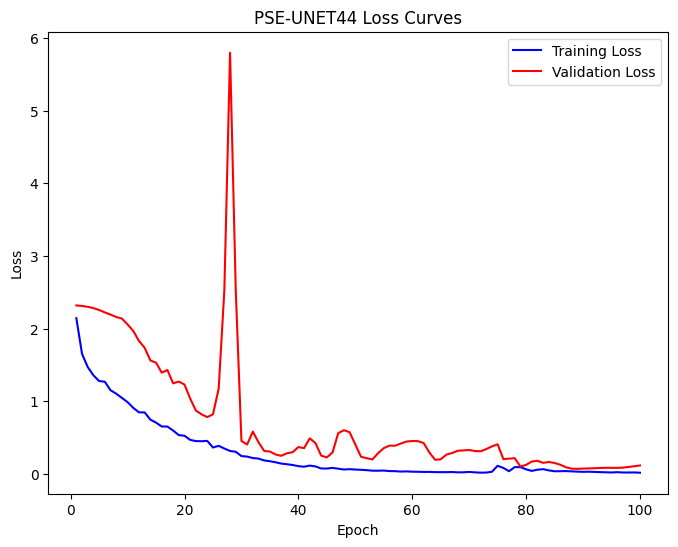

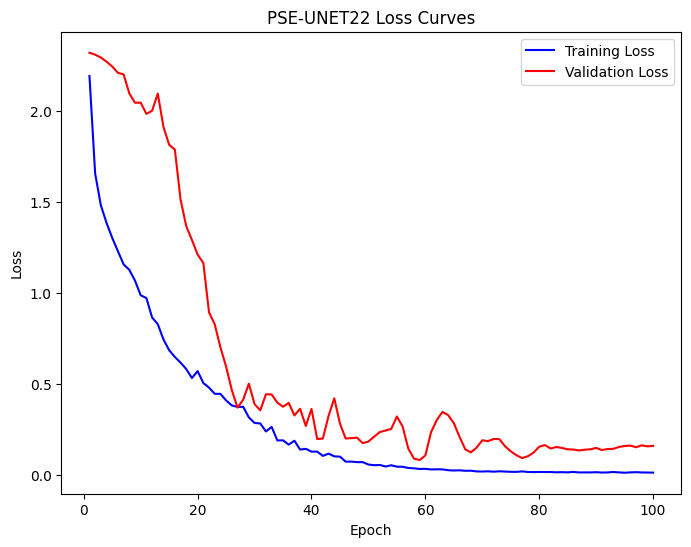

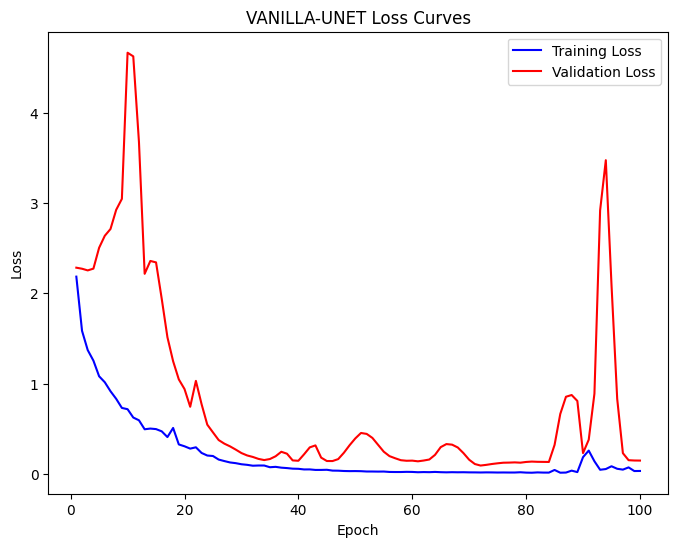

In [196]:
#----------------------------------------------------------------------------------------------------------
# Training and Evaluation Loops

def trainRoutine(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)  # Shape: (B, n_classes, H, W)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

def evalRoutine(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)
#----------------------------------------------------------------------------------------------------------

num_epochs = 100

pse44TrainLosses = []
pse44ValLosses = []

pse22TrainLosses = []
pse22ValLosses = []

vunetTrainLosses = []
vunetValLosses = []

print("Training vanilla-unet...")
for epoch in range(num_epochs):
    vTrainLoss = trainRoutine(vunet, train_loader, vunetOptim, loss_fn, device)
    vVallLoss = evalRoutine(vunet, val_loader, loss_fn, device)
    vunetScheduler.step(vVallLoss)
    vunetTrainLosses.append(vTrainLoss)
    vunetValLosses.append(vVallLoss)
    # Print current status, including current learning rate.
    current_lr = vunetOptim.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {vTrainLoss:.4f}, Val Loss = {vVallLoss:.4f}, LR = {current_lr:.6f}")
    print("Training complete...")


print("\n\nTraining pseunet44...")
for epoch in range(num_epochs):
    pse44TrainLoss = trainRoutine(pseunet44, train_loader, pse44Optim, loss_fn, device)
    pse44ValLoss = evalRoutine(pseunet44, val_loader, loss_fn, device)
    pse44Scheduler.step(pse44ValLoss)
    pse44TrainLosses.append(pse44TrainLoss)
    pse44ValLosses.append(pse44ValLoss)
    # Print current status, including current learning rate.
    current_lr = pse44Optim.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {pse44TrainLoss:.4f}, Val Loss = {pse44ValLoss:.4f}, LR = {current_lr:.6f}")
print("Training complete...")


print("\n\nTraining pseunet22...")
for epoch in range(num_epochs):
    pse22TrainLoss = trainRoutine(pseunet22, train_loader, pse22Optim, loss_fn, device)
    pse22ValLoss = evalRoutine(pseunet22, val_loader, loss_fn, device)
    pse22Scheduler.step(pse22ValLoss)
    pse22TrainLosses.append(pse22TrainLoss)
    pse22ValLosses.append(pse22ValLoss)
    # Print current status, including current learning rate.
    current_lr = pse22Optim.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {pse22TrainLoss:.4f}, Val Loss = {pse22ValLoss:.4f}, LR = {current_lr:.6f}")
print("Training complete...")

#----------------------------------------------------------------------------------------------------------

# Plot loss curves.

def plotLoss(modelName, train_losses, val_losses):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{modelName} Loss Curves')
    plt.legend()
    plt.show()


#----------------------------------------------------------------------------------------------------------

plotLoss('PSE-UNET44', pse44TrainLosses, pse44ValLosses)
plotLoss('PSE-UNET22', pse22TrainLosses, pse22ValLosses)
plotLoss('VANILLA-UNET', vunetTrainLosses, vunetValLosses)

#### Compute and Plot the Confusion Matrix

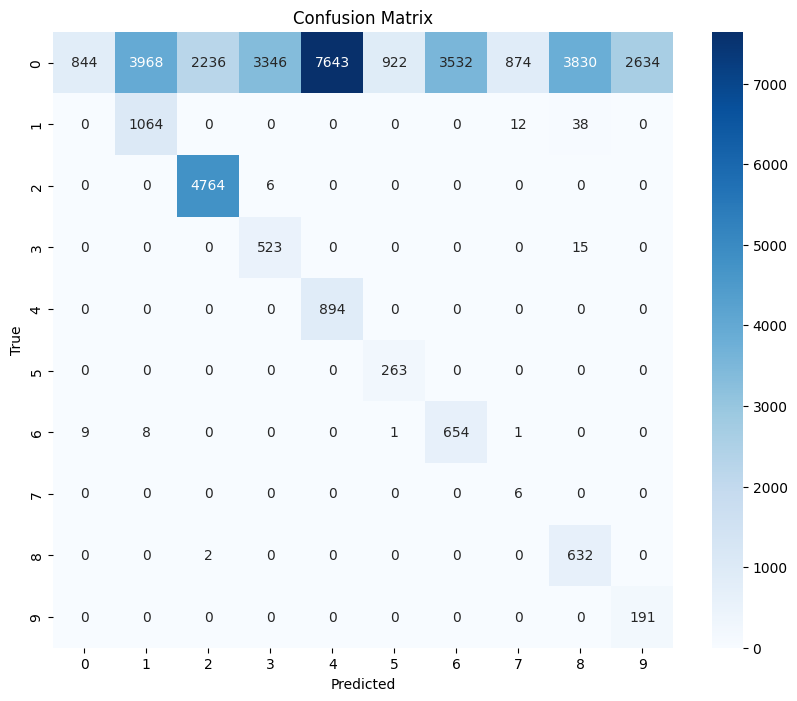

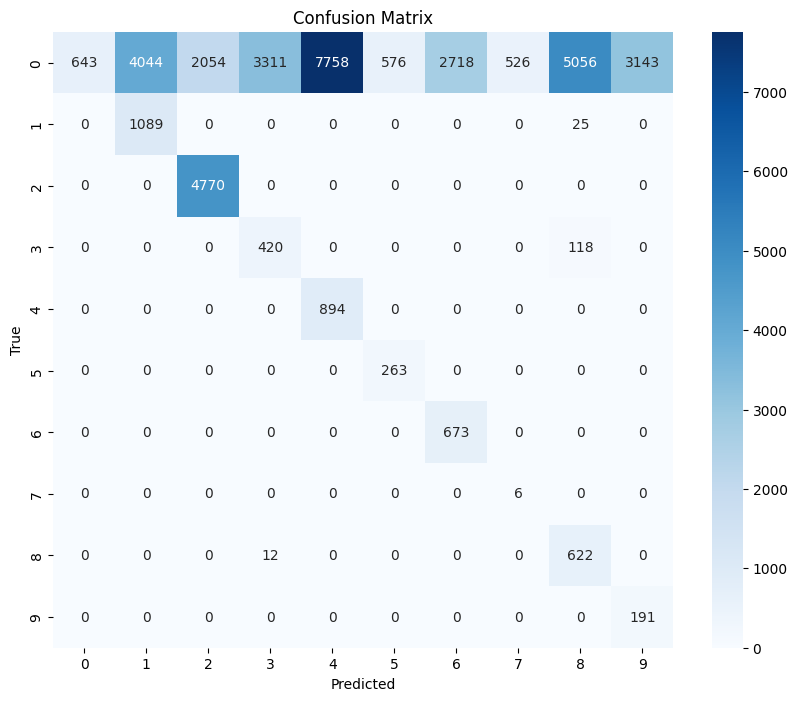

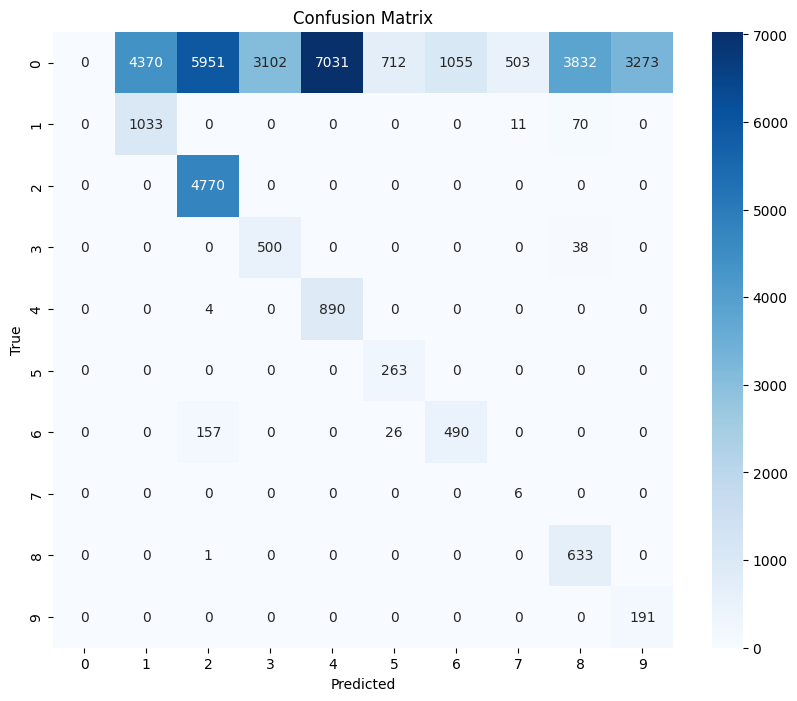

In [197]:
def plotCMatrix(model, loader, device, num_classes):
    """
    Computes and plots a pixel-wise confusion matrix for segmentation.
    
    Args:
        model: Trained segmentation model.
        loader: DataLoader for the evaluation set.
        device: Device (CPU/GPU).
        num_classes: Number of segmentation classes.
    """
    all_true = []
    all_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_true.append(targets.view(-1).cpu().numpy())
            all_pred.append(preds.view(-1).cpu().numpy())
    
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)
    
    cm = confusion_matrix(all_true, all_pred, labels=range(num_classes))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(num_classes),
                yticklabels=range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Compute confusion matrix on validation set.
plotCMatrix(pseunet44, val_loader, device, num_classes=n_classes)
plotCMatrix(pseunet22, val_loader, device, num_classes=n_classes)
plotCMatrix(vunet, val_loader, device, num_classes=n_classes)


#### Evaluation metrics

In [ ]:


#----------------------------------------------------------------------------------------------------------
def compute_mIoU(true_labels, pred_labels, n_classes, ignore_index=ignore_index):
    """
    Compute the mean Intersection over Union (mIoU) for segmentation results.
    
    Args:
        true_labels (numpy array): Flattened ground truth labels.
        pred_labels (numpy array): Flattened predicted labels.
        n_classes (int): Total number of classes.
        ignore_index (int, optional): Class label to ignore in evaluation (e.g., background).
    
    Returns:
        float: The average IoU across all classes (ignoring NaN values).
    """
    ious = []
    for cls in range(n_classes):
        # If we are ignoring a particular class, skip it.
        if ignore_index is not None and cls == ignore_index:
            continue
        # Create binary masks for the current class.
        true_mask = (true_labels == cls)
        pred_mask = (pred_labels == cls)
        # Calculate intersection and union.
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()
        
        if union == 0:
            # If there is no ground truth for this class, we can skip or mark it as NaN.
            iou = np.nan
        else:
            iou = intersection / union
        ious.append(iou)
    # Return the mean IoU ignoring any NaN values
    mIoU = np.nanmean(ious)
    return mIoU
#----------------------------------------------------------------------------------------------------------


#----------------------------------------------------------------------------------------------------------
def compute_kappa(true_labels, pred_labels):
    """
    Compute Cohen's Kappa score for segmentation results.
    
    Args:
        true_labels (numpy array): Flattened ground truth labels.
        pred_labels (numpy array): Flattened predicted labels.
    
    Returns:
        float: Cohen's Kappa score.
    """
    return cohen_kappa_score(true_labels, pred_labels)
#----------------------------------------------------------------------------------------------------------

def compute_accuracy(true_labels, pred_labels):
 
    correct = np.sum(true_labels == pred_labels)
    total = true_labels.size
    accuracy = correct / total
    return accuracy


#----------------------------------------------------------------------------------------------------------
def evaluate_segmentation_metrics(model, loader, device, n_classes, ignore_index=None):
    """
    Evaluate segmentation metrics (mIoU, Cohen's Kappa, and Accuracy) for the given model and data.

    Args:
        model (nn.Module): The segmentation model.
        loader (DataLoader): DataLoader for the dataset to evaluate (e.g., validation or test set).
        device (torch.device): The device to run inference on.
        n_classes (int): Total number of segmentation classes.
        ignore_index (int, optional): Class index to ignore in the evaluation (e.g., background).

    Returns:
        tuple: (mIoU, kappa, accuracy) computed over the entire dataset.
    """
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # shape: (B, n_classes, H, W)
            # Get predicted class per pixel.
            _, preds = torch.max(outputs, 1)
            # Flatten targets and predictions and move to CPU.
            all_true.append(targets.view(-1).cpu().numpy())
            all_pred.append(preds.view(-1).cpu().numpy())

    # Concatenate lists into single numpy arrays.
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)

    # Compute evaluation metrics.
    miou = compute_mIoU(all_true, all_pred, n_classes, ignore_index=ignore_index)
    kappa = compute_kappa(all_true, all_pred)
    accuracy = compute_accuracy(all_true, all_pred)

    return miou, kappa, accuracy


miou_val, kappa_val, accuracy_val = evaluate_segmentation_metrics(pseunet44, val_loader, device, n_classes, ignore_index=ignore_index)
print("PSE-UNET44 Validation Metrics:")
print("  Mean IoU:", miou_val)
print("  Cohen's Kappa:", kappa_val)
print("  Accuracy:", accuracy_val)

#----------------------------------------------------------------------------------------------------------


# Assume n_classes is defined as:
n_classes = int(y.max()) + 1  # Total number of classes in your dataset


# Evaluate the model on the validation set.
miou_val, kappa_val, acc44 = evaluate_segmentation_metrics(pseunet44, val_loader, device, n_classes, ignore_index=ignore_index)
print("\nPSE-UNET44 Validation Metrics:")
print("  Mean IoU:", miou_val)
print("  Cohen's Kappa:", kappa_val)
print("  Accuracy:", acc44)

# You can similarly run this for the other models.
miou_val_vunet, kappa_val_vunet, vuAcc = evaluate_segmentation_metrics(vunet, val_loader, device, n_classes, ignore_index=ignore_index)
print("\nVANILLA-UNET Validation Metrics:")
print("  Mean IoU:", miou_val_vunet)
print("  Cohen's Kappa:", kappa_val_vunet)
print("  Accuracy:", vuAcc)

miou_val_pse22, kappa_val_pse22, acc22 = evaluate_segmentation_metrics(pseunet22, val_loader, device, n_classes, ignore_index=ignore_index)
print("\nPSE-UNET22 Validation Metrics:")
print("  Mean IoU:", miou_val_pse22)
print("  Cohen's Kappa:", kappa_val_pse22)
print("  Accuracy:", acc22)




PSE-UNET44 Validation Metrics:
  Mean IoU: 0.1910586801476842
  Cohen's Kappa: 0.21067472088354322
  Accuracy: 0.25274979440789475

PSE-UNET44 Validation Metrics:
  Mean IoU: 0.1910586801476842
  Cohen's Kappa: 0.21067472088354322
  Accuracy: 0.25274979440789475

VANILLA-UNET Validation Metrics:
  Mean IoU: 0.18085554536133852
  Cohen's Kappa: 0.18697189803134817
  Accuracy: 0.2255345394736842

PSE-UNET22 Validation Metrics:
  Mean IoU: 0.20104189185205545
  Cohen's Kappa: 0.2072032635230473
  Accuracy: 0.24596525493421054


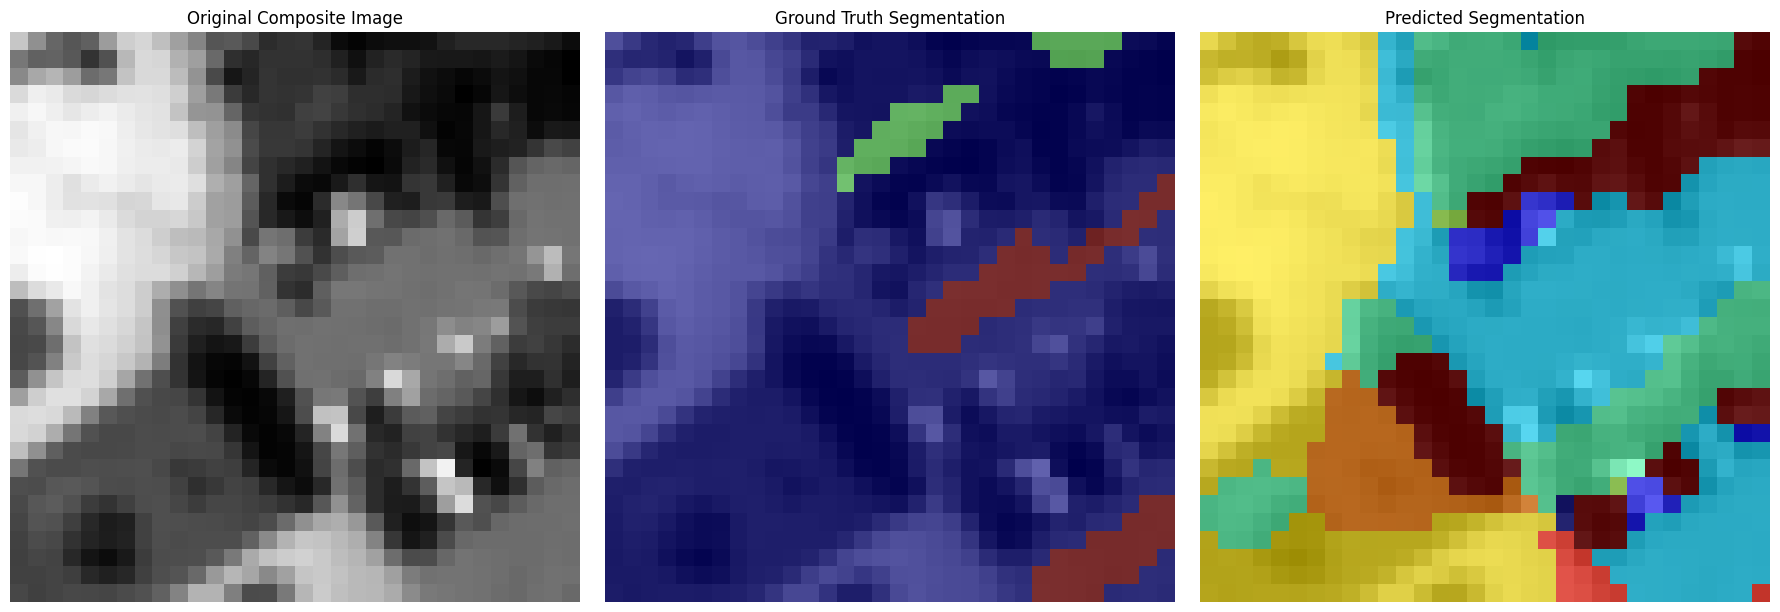

In [199]:


def visualize_segmentation(original_img, true_segmentation, pred_segmentation):
    """
    Visualize the original composite image, ground truth, and predicted segmentation maps.
    
    Args:
        original_img (numpy array): The original image for context (grayscale or RGB composite).
        true_segmentation (numpy array): The 2D ground truth segmentation map.
        pred_segmentation (numpy array): The 2D predicted segmentation map.
    """
    plt.figure(figsize=(18, 6))
    
    # Original image.
    plt.subplot(1, 3, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Composite Image")
    plt.axis('off')
    
    # Ground truth overlay.
    plt.subplot(1, 3, 2)
    plt.imshow(original_img, cmap='gray')
    plt.imshow(true_segmentation, cmap='jet', alpha=0.6)
    plt.title("Ground Truth Segmentation")
    plt.axis('off')
    
    # Predicted segmentation overlay.
    plt.subplot(1, 3, 3)
    plt.imshow(original_img, cmap='gray')
    plt.imshow(pred_segmentation, cmap='jet', alpha=0.6)
    plt.title("Predicted Segmentation")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def get_sample_composite(patch):
    """
    Generate a composite for visualization from a patch tensor.
    In this simple example, we use the first channel of the patch as the composite image.
    In your case, if you have a function like ep.get_rgb to generate an RGB composite,
    you should use that instead.
    
    Args:
        patch (torch.Tensor): A tensor of shape (channels, H, W)
    
    Returns:
        numpy.ndarray: A 2D array for visualization.
    """
    # Convert patch to NumPy array.
    patch_np = patch.cpu().numpy()
    # Use the first channel as a grayscale composite.
    composite = patch_np[0, :, :]
    return composite

# ---------------------------------------------------------------------------
# Obtain a sample patch from the test dataset.
sample_patch, sample_gt = testSet[0]  # sample_patch: (C, H, W); sample_gt: (H, W)

# Convert the sample_patch to the proper device.
sample_patch = sample_patch.to(device)

# Add batch dimension.
sample_patch_batch = sample_patch.unsqueeze(0)  # shape becomes (1, C, H, W)

# Run the model (e.g., pseunet44) for inference.
pseunet44.eval()
with torch.no_grad():
    outputs = pseunet44(sample_patch_batch)  # Outputs shape: (1, n_classes, H, W)
    # Get predicted segmentation: take argmax over the class channel.
    _, sample_pred = torch.max(outputs, dim=1)  # shape: (1, H, W)
sample_pred = sample_pred.squeeze(0).cpu().numpy()  # shape becomes (H, W)

# Convert ground truth to NumPy (if needed).
sample_gt_np = sample_gt.cpu().numpy() if hasattr(sample_gt, 'cpu') else sample_gt

# Generate an original composite image for visualization from the sample patch.
# You might use your composite generating function if available;
# here we simply use the first channel.
composite_img = get_sample_composite(sample_patch)

# Visualize segmentation overlay.
visualize_segmentation(composite_img, sample_gt_np, sample_pred)
